In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.adiabatic_pulse_calib
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported e

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.getcwd()+'\data\data_230927'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230927


In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [7]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 6100000000.0
set power to 10.0


In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

# Run protocol

time step size [cycles]: 2
timesteps [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295
 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355
 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415
 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475
 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535
 0.54  0.545 0.55  0.555 0.56  0.565 0.57  0.575 0.58  0.585 0.59  0.595
 0.6   0.605 0.61  0.615 0.62  0.625 0.63  0.635 0.64  0.645 0.65  0.655
 0.66  0.665 0.67  0.675 0.68  0.685 0.69  0.695 0.7   0.705 0.71  0.715
 0.72  0.725 0.73  0.735 0.74  0.745 0.75  0.755 0.76  0.765 0.77  0.775
 0.78  0.785 0

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)


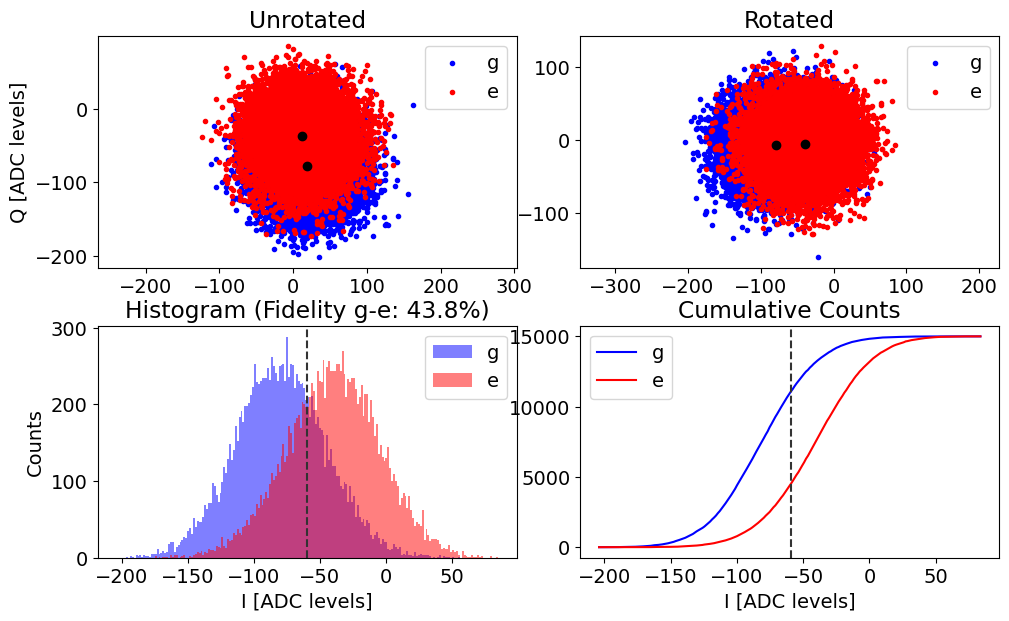

ge fidelity (%): 43.80812693756459 	 angle (deg): -99.22086545944408 	 threshold ge: -59.37381845858263
Qubit (1)


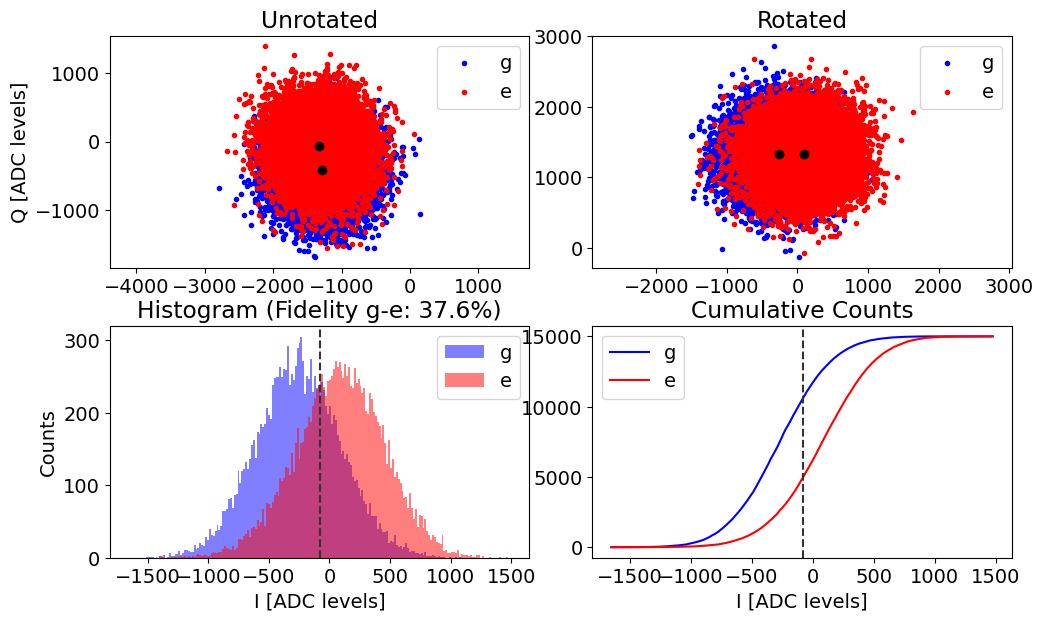

ge fidelity (%): 37.601253375112506 	 angle (deg): -97.01254725819359 	 threshold ge: -82.04042072948687


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)


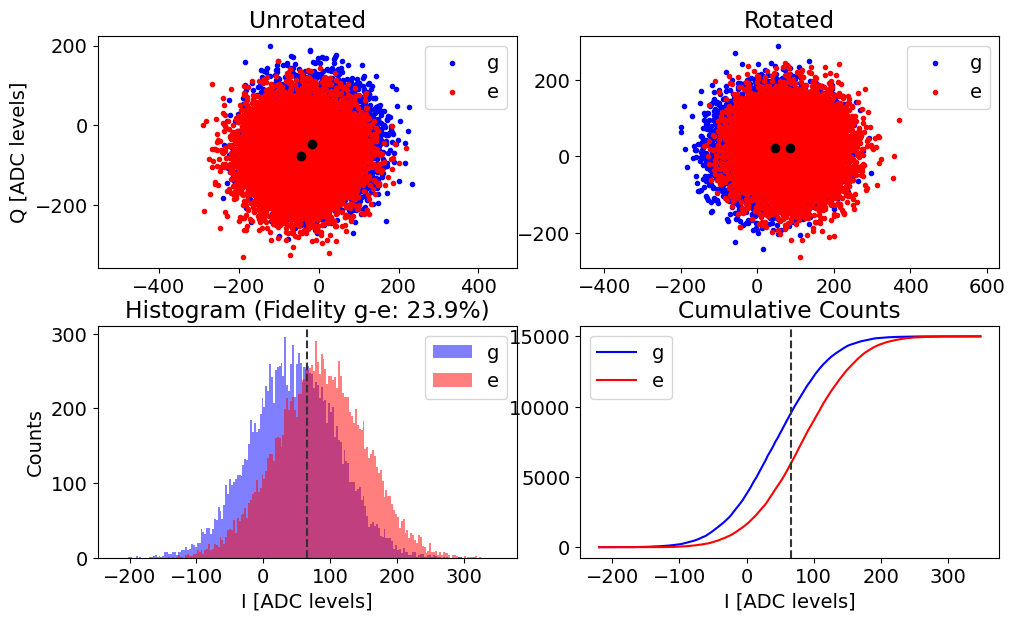

ge fidelity (%): 23.915724905823915 	 angle (deg): 134.1658096086023 	 threshold ge: 65.7746413457553
Qubit  (3)


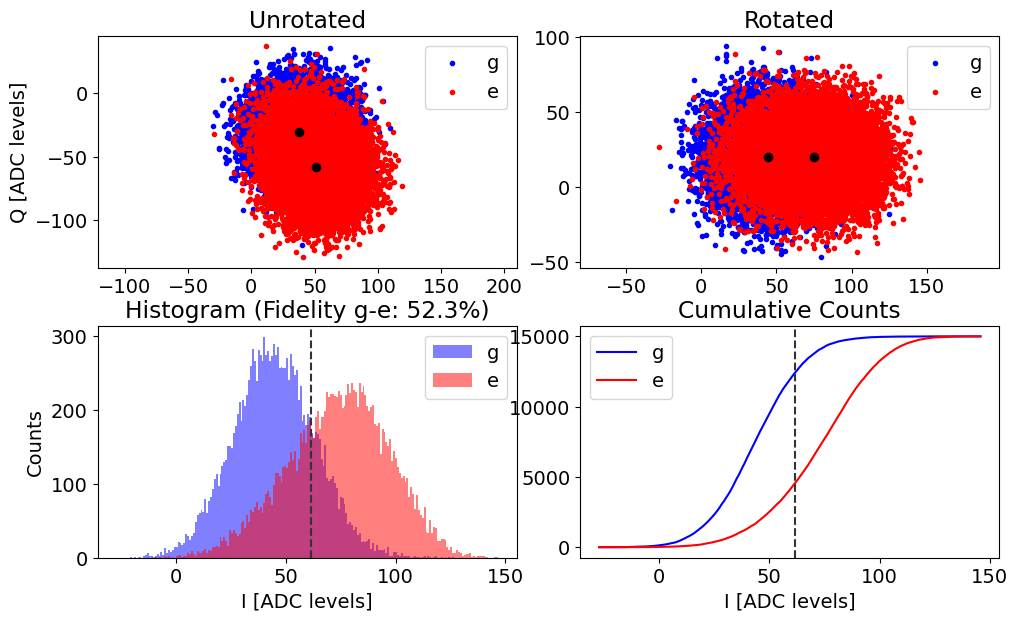

ge fidelity (%): 52.315077169238975 	 angle (deg): 63.59402614248629 	 threshold ge: 61.476288246405595
thresholds=[-59.37381845858263, -82.04042072948687, 65.7746413457553, 61.476288246405595]
angles=[-99.22086545944408, -97.01254725819359, 134.1658096086023, 63.59402614248629]
ge_avgs=[[18.81471832574279, -77.29535285187593, 12.197749295163739, -38.3170823248753], [-1288.222103057905, -414.86836729559747, -1330.068081977879, -76.05307004988073], [-17.022846584255042, -47.24956443287791, -45.34276035567122, -75.38658911299068], [38.23942919106484, -31.040791151594014, 51.17603318152244, -56.96335220125786]]


  0%|          | 0/300 [00:00<?, ?it/s]

end times [0.06, 0.12, 0.52, 0.92, 1.0035473346443655, 1.0870946692887309, 1.147094669288731, 1.207094669288731]


In [10]:
qramExpt = meas.QramProtocolExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
    prefix=f"4q_meas_example_pi0_pi0_pi1_pi1_pi2_pi2_pi3_pi3",
)

span = 1.5 # total time [us]
npts = 300
print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    init_state='|0>|0>',
    start=0, # start protocol time [us],
    step=span/npts, # time step [us], 
    expts=npts, # number of different time experiments, 
    reps=5000, # number of reps per time step,
    post_process='scale', # if true, uses threshold
    singleshot_reps=15000, # reps per state for singleshot calibration
    tomo_2q=False, # True/False whether to do 2q state tomography on state at last time step

    tomo_qubits=[0,1], # the qubits on which to do the 2q state tomo
    # thresholds=[23.179328085510463, 332.7232840438514, 421.8517625963923, -543.9946460140202],
    # angles=[-48.357727278342495, 179.3655091117251, 115.79976713495705, -41.070213273522114],
    # ge_avgs=[[55.440479824275954, -30.180420403514482, 60.194047608200464, -24.435568532378785], [-320.85002892938496, -124.93121298405468, -353.2516422388545, -125.4138010087862], [-697.5731328018223, -115.1149874064432, -709.8174383338757, -139.8462430198503], [101.2080142531728, -943.8882348519362, 106.53187344614383, -939.3874330296127]]
)

# qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [11]:
# import numpy as np
# np.where(np.array([2, 1])==2)[0][0]
# calib_state = 'gg'
# qi = np.where(np.array([2,1])==1)[0][0]
# calib_state = calib_state[:qi] + 'e' + calib_state[qi+1:]
# calib_state

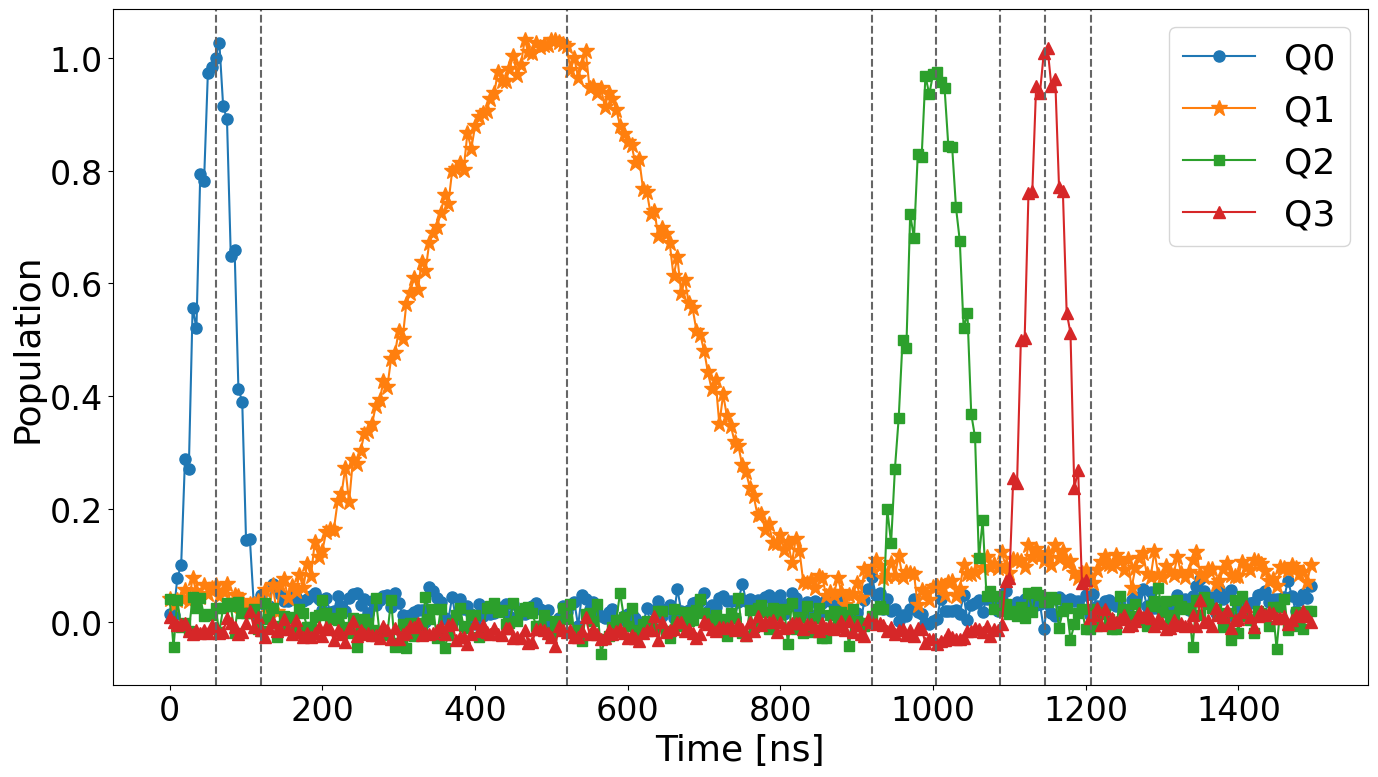

In [12]:
qramExpt.analyze()
qramExpt.display(err=False)

In [13]:
qramExpt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00001_4q_meas_example_pi0_pi0_pi1_pi1_pi2_pi2_pi3_pi3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230927\\00001_4q_meas_example_pi0_pi0_pi1_pi1_pi2_pi2_pi3_pi3.h5'

C:\Users\slab\AppData\Local\Temp\ipykernel_20168\217307492.py:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  temp_data.update({key:np.array(a[key])})


Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
0 250 -1 0.037551191241965584
1 250 -1 0.0913747167731195
2 250 -1 0.012638025274952919
3 250 -1 0.005555707647104143


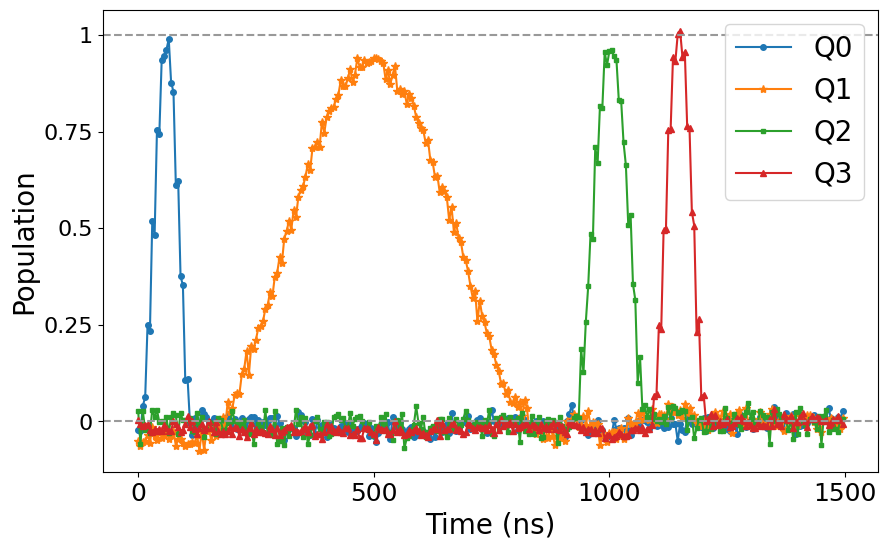

In [8]:
data, attrs = prev_data(expt_path, '00001_4q_meas_example_pi0_pi0_pi1_pi1_pi2_pi2_pi3_pi3.h5')

xpts_ns = data['xpts']*1e3

# ---- Subtract off baseline for when there are no coupled qubits in excited state ---- #
ti = np.argmin(np.abs(xpts_ns - 1250))
tf = -1

for q in range(4):
    q_baseline = np.average(data['avgi'][q][ti:tf])
    # plt.axhline(q_baseline, color='0.6', linestyle='--')
    print(q, ti, tf, q_baseline)
    data['avgi'][q] -= q_baseline

data_q0_raw = data["avgi"][0]
data_q1_raw = data["avgi"][1]
data_q2_raw = data["avgi"][2]
data_q3_raw = data["avgi"][3]


data_q = ([], [], [], [])
xpts_ns_smoothed = []

# test = np.arange(len(data_q0_raw))
# print(len(data_q0_raw))

window_size = 1
start_window = 0
for q, data_raw in enumerate((data_q0_raw, data_q1_raw, data_q2_raw, data_q3_raw)):
    # smoothing over window
    if start_window > 0:
        data_q[q].append(data_raw[:start_window])
        if q == 0: xpts_ns_smoothed.append(xpts_ns[:start_window])
    for n in range(1, (len(data_raw) - start_window)//window_size + 1):
        # print(n, test[(n-1)*window_size+start_window:n*window_size+start_window])
        if q == 0: xpts_ns_smoothed.append(np.average(xpts_ns[(n-1)*window_size+start_window:n*window_size+start_window]))
        data_q[q].append(np.average(data_raw[(n-1)*window_size+start_window:n*window_size+start_window]))
    if (len(data_raw) - start_window) % window_size > 0:
        n = (len(data_raw) - start_window)//window_size
        print(test[n*window_size+start_window:])
        if q == 0: xpts_ns_smoothed.append(np.average(xpts_ns[n*window_size+start_window:]))
        data_q[q].append(np.average(data_raw[n*window_size+start_window:]))

plt.plot(xpts_ns_smoothed, data_q[0], '-', marker='o', markersize=4, label='Q0')
plt.plot(xpts_ns_smoothed, data_q[1], '-', marker='*', markersize=6, label='Q1')
plt.plot(xpts_ns_smoothed, data_q[2], '-', marker='s', markersize=3, label='Q2')
plt.plot(xpts_ns_smoothed, data_q[3], '-', marker='^', markersize=4, label='Q3')
plt.axhline(0, color='0.6', linestyle='--')
plt.axhline(1, color='0.6', linestyle='--')

plt.legend(fontsize=20, loc='upper right')
plt.xticks([0, 500, 1000, 1500], fontsize=18)
plt.yticks([0, 0.25, 0.5, 0.75, 1], labels=['0', '0.25', '0.5', '0.75', '1'], fontsize=16)
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel("Population", fontsize=20)

plt.savefig('mux_readout_expt.pdf')
plt.show()
